<a href="https://colab.research.google.com/github/Geoffrey256/meta-learning-final-year/blob/main/Final_Year_Prototypical_Nerworks_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install torch torchvision scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# prompt: load dataset

import pandas as pd


dataset_path = '/content/drive/MyDrive/Medical_Waste_Dataset'




In [ ]:
# Dataset Loader for Few-Shot Tasks

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import random

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def get_image_folders(root_dir):
    return datasets.ImageFolder(root=root_dir, transform=transform)

train_dataset = get_image_folders('/content/drive/MyDrive/Medical_Waste_Dataset/train')
val_dataset = get_image_folders('/content/drive/MyDrive/Medical_Waste_Dataset/val')
test_dataset = get_image_folders('/content/drive/MyDrive/Medical_Waste_Dataset/test')


In [ ]:
#define prototypicla networks with pretrained resnet 18 for feature extraction
import torch.nn as nn
import torch
from torchvision.models import resnet18

class ProtoNet(nn.Module):
    def __init__(self, output_dim=256):
        super().__init__()
        backbone = resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(backbone.children())[:-1])
        self.output = nn.Linear(backbone.fc.in_features, output_dim)

    def forward(self, x):
        x = self.encoder(x).squeeze()
        x = self.output(x)
        return x


In [ ]:
#proptypical loss function
def compute_prototypes(support_embeddings, support_labels, n_way):
    prototypes = []
    for i in range(n_way):
        class_embeddings = support_embeddings[support_labels == i]
        prototype = class_embeddings.mean(dim=0)
        prototypes.append(prototype)
    return torch.stack(prototypes)

def prototypical_loss(prototypes, query_embeddings, query_labels):
    dists = torch.cdist(query_embeddings, prototypes)  # [n_query, n_way]
    log_p_y = (-dists).log_softmax(dim=1)
    loss = nn.NLLLoss()(log_p_y, query_labels)
    _, y_hat = log_p_y.max(1)
    acc = (y_hat == query_labels).float().mean()
    return loss, acc.item()


In [ ]:
#training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ProtoNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(FewShotDataset(train_dataset, n_way=5, k_shot=5, q_queries=15, num_episodes=100), batch_size=1)

for epoch in range(10):
    model.train()
    total_loss, total_acc = 0, 0

    for support_imgs, support_labels, query_imgs, query_labels in train_loader:
        support_imgs = support_imgs.squeeze(0).to(device)
        query_imgs = query_imgs.squeeze(0).to(device)
        support_labels = support_labels.squeeze(0).to(device)
        query_labels = query_labels.squeeze(0).to(device)

        optimizer.zero_grad()
        all_imgs = torch.cat([support_imgs, query_imgs], dim=0)
        embeddings = model(all_imgs)
        support_embeddings = embeddings[:len(support_imgs)]
        query_embeddings = embeddings[len(support_imgs):]

        prototypes = compute_prototypes(support_embeddings, support_labels, n_way=5)
        loss, acc = prototypical_loss(prototypes, query_embeddings, query_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc

    print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Acc={total_acc/len(train_loader):.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


Epoch 1: Loss=17.2348, Acc=0.9508
Epoch 2: Loss=0.9668, Acc=0.9971
Epoch 3: Loss=0.8717, Acc=0.9973
Epoch 4: Loss=0.9512, Acc=0.9957
Epoch 5: Loss=0.6569, Acc=0.9973
Epoch 6: Loss=0.4853, Acc=0.9983
Epoch 7: Loss=0.6603, Acc=0.9965
Epoch 8: Loss=0.4415, Acc=0.9983
Epoch 9: Loss=0.5043, Acc=0.9981
Epoch 10: Loss=0.6168, Acc=0.9971


In [ ]:
#saving the model
torch.save(model.state_dict(), 'protonet_medical_waste.pkle')




NameError: name 'torch' is not defined

In [ ]:
#saving the model
torch.save(model.state_dict(), 'protonet_medical_waste.pth')

In [ ]:
def __getitem__(self, idx):
    support_images, support_labels = [], []
    query_images, query_labels = [], []

    # Select classes that have enough samples
    eligible_classes = [cls for cls, indices in self.class_to_indices.items()
                        if len(indices) >= self.k_shot + self.q_queries]

    if len(eligible_classes) < self.n_way:
        raise ValueError(f"Not enough eligible classes with at least {self.k_shot + self.q_queries} samples. "
                         f"Found {len(eligible_classes)} but need {self.n_way}.")

    classes = random.sample(eligible_classes, self.n_way)

    for i, cls in enumerate(classes):
        indices = random.sample(self.class_to_indices[cls], self.k_shot + self.q_queries)
        support_idx = indices[:self.k_shot]
        query_idx = indices[self.k_shot:]

        for si in support_idx:
            image, _ = self.dataset[si]
            support_images.append(image)
            support_labels.append(i)

        for qi in query_idx:
            image, _ = self.dataset[qi]
            query_images.append(image)
            query_labels.append(i)

    return torch.stack(support_images), torch.tensor(support_labels), \
           torch.stack(query_images), torch.tensor(query_labels)


In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt


import torch.nn as nn
import torch

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Conv Layer 1
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # Conv Layer 2
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # Conv Layer 3
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # Conv Layer 4
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # Global average pooling
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)  # Flatten for prototype comparison


XAI ON PROTONET


In [ ]:
!pip install torch torchvision captum shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import LayerGradCam, IntegratedGradients
import shap

In [ ]:
!pip install numpy==1.23.5 shap==0.41.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 92.2 MB/s eta 0:00:00
  Created wheel for shap: filename=shap-0.41.0-cp311-cp311-linux_x86_64.whl size=518507 sha256=1bef4c88958a9ab38153508a596bf891ed4768040eefe14aa535a989fb927d83
  Stored in directory: /root/.cache/pip/wheels/2a/ca/9d/d8f6a34c245842f4ad8e5afb5e8f217b8914f6d957d9e302fd
Successfully built shap
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: shap
    Found existing installation: shap 0.47.2
    Uninstalling shap-0.47.2:
      Succ

In [ ]:
import torch
import torch.nn as nn

class ProtonetBackbone(nn.Module):
    def __init__(self):
        super(ProtonetBackbone, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # encoder.0
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # encoder.3
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # encoder.6
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        return x

# Instantiate the model
model = ProtonetBackbone()

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import LayerGradCam, IntegratedGradients
import shap

In [ ]:
import torch

# Load the state dict
model_path = '/content/drive/MyDrive/prototypical_network.pth'
state_dict = torch.load(model_path, map_location=torch.device('cpu'))

# Print all keys in the state dict
print("State dict keys:", state_dict.keys())

State dict keys: odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.3.weight', 'encoder.3.bias', 'encoder.6.weight', 'encoder.6.bias'])


In [ ]:
# Load the model
model_path = '/content/drive/MyDrive/prototypical_network.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.9MB/s]


Error loading /content/drive/MyDrive/Medical_Waste_Dataset/test/sharps/20250320_171736.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Medical_Waste_Dataset/test/sharps/20250320_171736.jpg'
Error loading /content/drive/MyDrive/Medical_Waste_Dataset/test/sharps/20250320_171737.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Medical_Waste_Dataset/test/sharps/20250320_171737.jpg'
Error loading /content/drive/MyDrive/Medical_Waste_Dataset/test/sharps/20250320_171738.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Medical_Waste_Dataset/test/sharps/20250320_171738.jpg'
Error loading /content/drive/MyDrive/Medical_Waste_Dataset/test/sharps/20250320_171739.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/Medical_Waste_Dataset/test/sharps/20250320_171739.jpg'
Input batch shape: torch.Size([1, 3, 84, 84])


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Usin

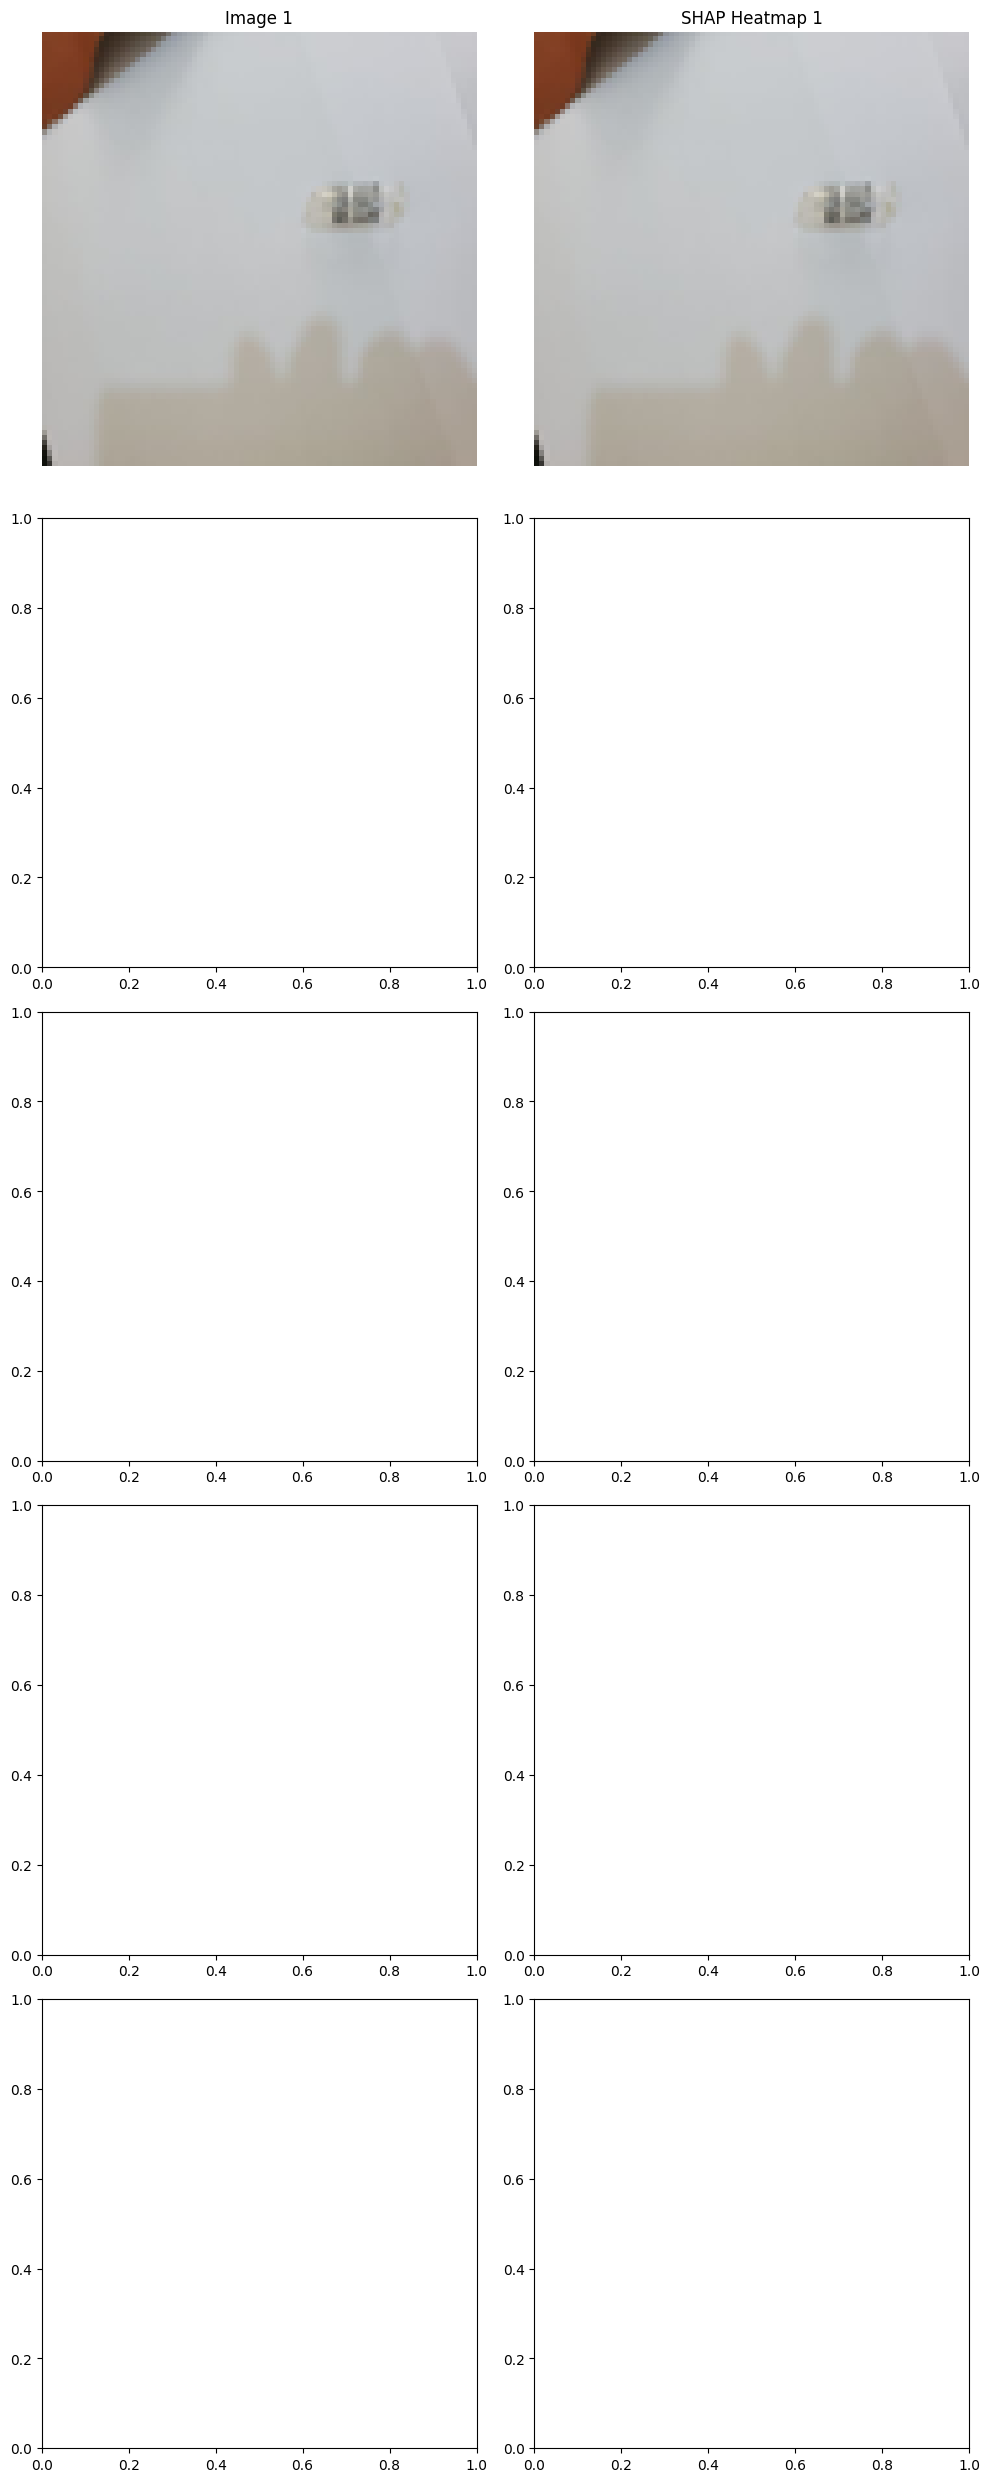

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import shap
import numpy as np

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize((84, 84)),  # Common for miniImageNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load pre-trained model (e.g., ResNet18)
model = models.resnet18(pretrained=True).to(device)
model.eval()

# List of image paths (replace with your actual paths)
image_paths = [
    '/content/drive/MyDrive/Medical_Waste_Dataset/test/sharps/20250320_171735.jpg',
    '/content/drive/MyDrive/Medical_Waste_Dataset/test/sharps/20250320_171736.jpg',
    '/content/drive/MyDrive/Medical_Waste_Dataset/test/sharps/20250320_171737.jpg',
    '/content/drive/MyDrive/Medical_Waste_Dataset/test/sharps/20250320_171738.jpg',
    '/content/drive/MyDrive/Medical_Waste_Dataset/test/sharps/20250320_171739.jpg'
]

# Load and preprocess images
images = []
input_tensors = []
for path in image_paths:
    try:
        image = Image.open(path).convert('RGB')
        images.append(image)
        input_tensor = preprocess(image).unsqueeze(0).to(device)
        input_tensors.append(input_tensor)
    except Exception as e:
        print(f"Error loading {path}: {e}")
        continue

# Stack tensors for batch processing
input_batch = torch.cat(input_tensors, dim=0)  # Shape: [5, 3, 84, 84]
print(f"Input batch shape: {input_batch.shape}")

# Prepare SHAP explainer
# Use a subset of images as background (e.g., first image)
background = input_batch[:1]  # Use one image as background for simplicity
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values for the batch
shap_values = explainer.shap_values(input_batch)

# Create a 5x2 subplot grid
fig, axes = plt.subplots(5, 2, figsize=(10, 25))

for i in range(len(images)):
    # Original image
    axes[i, 0].imshow(images[i].resize((84, 84)))
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Image {i+1}')

    # SHAP heatmap
    # Use the first output class for simplicity (or adjust based on your task)
    shap_image = shap_values[0][i]  # SHAP values for class 0, image i
    # Rescale SHAP values for visualization
    shap_image = np.sum(shap_image, axis=0)  # Sum across channels
    shap_image = (shap_image - shap_image.min()) / (shap_image.max() - shap_image.min())  # Normalize

    axes[i, 1].imshow(images[i].resize((84, 84)))
    axes[i, 1].imshow(shap_image, cmap='jet', alpha=0.5)  # Overlay SHAP heatmap
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'SHAP Heatmap {i+1}')

plt.tight_layout()
plt.show()

<ipython-input-10-3758441585>:21: RuntimeWarning: invalid value encountered in divide
  attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())


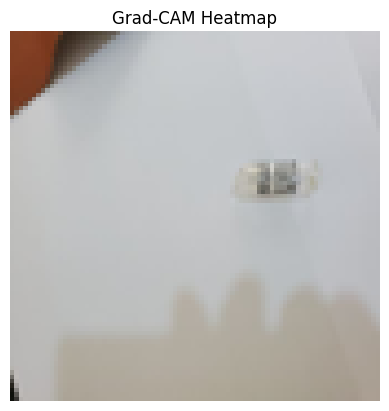

In [ ]:
from captum.attr import LayerGradCam
import torch.nn.functional as F

# Select the target layer for Grad-CAM
target_layer = model.encoder[6]  # Last conv layer (encoder.6)

# Initialize Grad-CAM
grad_cam = LayerGradCam(model, target_layer)

# Compute Grad-CAM attributions
# Target an output dimension (e.g., 0 for first embedding dimension)
attributions = grad_cam.attribute(input_tensor, target=0)

# Upsample attributions to match image size
attributions = F.interpolate(
    attributions, size=(84, 84), mode='bilinear', align_corners=False  # Match input size
)

# Normalize and convert to numpy for visualization
attributions = attributions.squeeze().cpu().detach().numpy()
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())

# Visualize Grad-CAM heatmap
plt.imshow(image.resize((84, 84)))  # Match upsampled size
plt.imshow(attributions, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Grad-CAM Heatmap')
plt.show()

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Usin

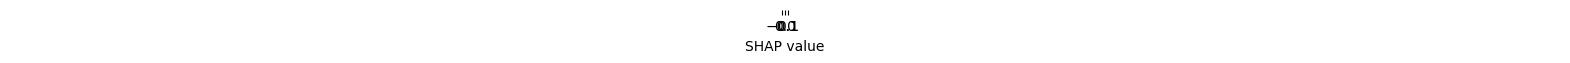

In [ ]:
import shap

# Define a function to pass the image through the model
def model_forward(x):
    return model(x)

# Create a SHAP explainer
explainer = shap.DeepExplainer(model, input_tensor)

# Compute SHAP values
shap_values = explainer.shap_values(input_tensor)

# Visualize SHAP values
shap.image_plot(shap_values, input_tensor.cpu().numpy().transpose(0, 2, 3, 1))

In [ ]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import shap